In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import random
import time

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torch.utils.data import sampler

# For plotting
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
from sklearn.model_selection import train_test_split

<h2>Training Helper Functions<h2>

In [316]:
def get_model_name(batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_epochs/densenetmodel_bs{0}_lr{1}_epoch{2}".format(
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion, device):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    target = torch.empty(1).to(device)
    returned = torch.empty(1).to(device)
    
    for i, data in enumerate(loader):
        #Input and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # Ensure outputs are squeezed and binary
        preds = (outputs > 0.0).squeeze().float()
        # Ensure labels are squeezed and in float format
        labels = labels.squeeze().float()

        # Compute the number of incorrect predictions
        # corr = preds != labels
        # incorrect_preds = corr.sum().item()

        # Stats
        # total_err += incorrect_preds  # Number of incorrect predictions
        total_loss += loss.item()
        # total_epoch += labels.size(0)

        # Add labels to target and outputs to returned
        target = torch.cat((target, labels))
        returned = torch.cat((returned, preds))
        
    target = target[1:]
    returned = returned[1:]

    # Initialize values
    cor = 0
    total_err = 0
    # get confusion matrix
    for i in range(len(target)):
        if target[i] == returned[i]:
            cor += 1
        else:
            total_err += 1
    total_epoch = len(target)


    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

<h2>Percision Matrix</h2>

In [332]:
def evaluate_model_scores(net, loader, device):
    # Initialize empty tensors to store results
    target = torch.empty(1).to(device)
    returned = torch.empty(1).to(device)

    for i, data in enumerate(loader):
    # 0 is mild-demented
    # 1 is non-demented

        # Get inputs and labels to pass to model
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get outputs from model
        outputs = net(inputs)
        outputs = (outputs > 0.0).squeeze().float()
        labels = (labels).squeeze().float()

        # Add labels to target and outputs to returned
        target = torch.cat((target, labels))
        returned = torch.cat((returned, outputs))

    # Remove initialized 0 at start of tensor
    target = target[1:]
    returned = returned[1:]

    # Initialize values
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0

    # get confusion matrix
    for i in range(len(target)):
        if target[i] == 1 and returned[i] == 1:
            true_pos += 1
        elif target[i] == 0 and returned[i] == 1:
            false_pos += 1
        elif target[i] == 1 and returned[i] == 0:
            false_neg += 1
        elif target[i] == 0 and returned[i] == 0:
            true_neg += 1
    print((true_pos + false_pos + true_neg + false_neg))

    # Create confusion matrix
    confusion_matrix = [true_pos, false_neg, false_pos, true_neg]

    # Calculate accuracy, precision, recall, f1
    accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
    precision = true_pos / (max(1,true_pos + false_pos))
    recall = true_pos / (max(1,true_pos + false_neg))
    f1 = (2 * recall * precision) / (max(1,recall + precision))

    f = open("model_results.txt", "w")
    f.write(f"confusion matrix: {confusion_matrix}\n\naccuracy: {accuracy}\n\nprecision: {precision}\n\nrecall: {recall}\n\nf1: {f1}")
    f.close()

    return confusion_matrix, accuracy, precision, recall, f1

def plot_confusion_matrix(values):

    
    """
    Plot confusion matrix given true positives, false positives, true negatives, and false negatives.
    
    Parameters:
    true_positives (int): Number of true positives.
    false_positives (int): Number of false positives.
    true_negatives (int): Number of true negatives.
    false_negatives (int): Number of false negatives.
    """
    labels = ['TP', 'FN', 'FP', 'TN']
    
    plt.figure(figsize=(6, 6))
    plt.imshow([values[:2], values[2:]], cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix', fontsize = 16)
    plt.xticks([0, 1], ['Predicted Positive', 'Predicted Negative'], fontsize = 14)
    plt.yticks([0, 1], ['Actual Positive', 'Actual Negative'], fontsize = 14)

    for i in range(2):
        for j in range(2):
            color = 'black' if (i == 0 and j == 0) or (i == 1 and j == 1) else 'black'
            plt.text(j, i, str(values[i*2 + j]), ha='center', va='center', color=color, fontsize=14)

    plt.colorbar()
    plt.show()


<h2>Data Loader</h2>

In [244]:
class Data(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = row.drop('catch').values.astype(float)
        target = row['catch']
        if isinstance(target, str):
            target = 1.0 if target == 'positive_label' else 0.0 
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)  
        return torch.tensor(features, dtype=torch.float32), target

def data_loader(file_name, data_percentage=0.4, batch_size=32):
    # Add columns of csv file to the following list
    header = ['distance','time', 'catch']
    
    # Load in data
    df = pd.read_csv(
        file_name,
        names=header,
        index_col=False, 
        skiprows = 1)
    
    df_train, df_valtest = train_test_split(df, test_size=0.3, random_state=50)
    df_val, df_test = train_test_split(df_valtest, test_size=0.33, random_state=50)
    
    train_data = Data(df_train)
    val_data = Data(df_val)
    test_data = Data(df_test)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


    return train_loader, val_loader, test_loader

    # Previous loading trials, not sure if working yet
    '''
    # Converts data to numpy array
    datanp = df.values.astype(np.float32)
    
    # Data to be used for training
    df = df[:int(data_percentage * len(datanp))]
    
    # set the numpy seed for reproducibility
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
    np.random.seed(50)
    np.random.shuffle(datanp)

    # Get 70% training data and labels
    train_data = datanp[:int(0.7 * len(datanp)), :-1]
    train_labels = datanp[:int(0.7 * len(datanp)), -1]

    # Get 20% validation data and labels
    val_data = datanp[int(0.7 * len(datanp)):int(0.9 * len(datanp)), :-1]
    val_labels = datanp[int(0.7 * len(datanp)):int(0.9 * len(datanp)), -1]

    # Get 10% testing data and labels
    test_data = datanp[int(0.9 * len(datanp)):, :-1]
    test_labels = datanp[int(0.9 * len(datanp)):, -1]
    
    # Generate loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
    
    return train_loader, val_loader, test_loader
    '''

<h2>Model Architecture</h2>

In [280]:
class catchProb(nn.Module):
    def __init__(self, num_features, num_classes):
        super(catchProb, self).__init__()
        self.num_features = num_features
        self.name = "catchProb"
        self.fc1 = nn.Linear(num_features, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 4)
        self.bn4 = nn.BatchNorm1d(4)
        self.fc5 = nn.Linear(4, num_classes)
    
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        
        
        x = self.fc2(x)
        x = F.relu(self.bn2(x))
        
        x = self.fc3(x)
        x = F.relu(self.bn3(x))
        
        x = self.fc4(x)
        x = F.relu(self.bn4(x))
        
        x = self.fc5(x)
        return x

<h2>Training Function</h2>

In [328]:
def train(net, device ,train_loader, valid_loader,test_loader, batch_size=32, learning_rate=0.001, num_epochs=10):
    net.train()

    # Freeze the weights for training
    for params in net.parameters():
        params.requires_grad = False

    # Attaching classifier to the pretrained model
    num_features = 2
    custom_classifier = catchProb(num_features, 1).to(device)
    net = custom_classifier.to(device)

    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    # optimizer = optim.AdamW(net.parameters(), learning_rate)
    decay_rate = 0.9
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate, betas=(decay_rate, 0.999))
    # optimizer = optim.SGD(net.parameters(), lr=0.001)
    # optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)


    train_error = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    valid_error = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)
    

    start_time = time.time()
    for epoch in range(num_epochs):
        target = torch.empty(1).to(device)
        returned = torch.empty(1).to(device)

        total_train_loss = 0.0
        total_train_error = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader):

            # Input and labels
            inputs, labels = data
            
            # # Move tensors to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()


            outputs = net(inputs)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            # Ensure outputs are squeezed and binary
            preds = (outputs > 0.0).squeeze().float()
            # Ensure labels are squeezed and in float format
            labels = (labels).squeeze().float()

            # # Compute the number of incorrect predictions
            # corr = preds != labels
            # incorrect_preds = corr.sum().item()

            # # Stats
            # total_train_error += incorrect_preds  # Number of incorrect predictions
            total_train_loss += loss.item()
            # total_epoch += labels.size(0)

            # Add labels to target and outputs to returned
            target = torch.cat((target, labels))
            returned = torch.cat((returned, preds))

        # Remove initialized 0 at start of tensor
        target = target[1:]
        returned = returned[1:]

        # Initialize values
        cor = 0
        total_train_error = 0
        # get confusion matrix
        for i in range(len(target)):
            if target[i] == returned[i]:
                cor += 1
            else:
                total_train_error += 1
        total_epoch = len(target)


        # Training error and loss
        train_error[epoch] = float(total_train_error) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        # Run validation tests
        valid_error[epoch], valid_loss[epoch] = evaluate(net, valid_loader, criterion, device)
        # Print results
        print(("Epoch {}: Train err: {}, Train loss: {} |" +
               "Validation err: {}, Validation loss: {}").format(
            epoch + 1,
            train_error[epoch],
            train_loss[epoch],
            valid_error[epoch],
            valid_loss[epoch]))
        model_path = get_model_name(batch_size, learning_rate, epoch)

        # Save the model
        model_scripted = torch.jit.script(net)
        model_scripted.save(f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    [matrix, accuracy, precision, recal, f1_score] = evaluate_model_scores(net, test_loader, device)
    plot_confusion_matrix(matrix)
    print('Test Accuracy: '+ str(accuracy))
    print('Test Precision: '+ str(precision))
    print('Test recal: '+ str(recal))
    print('Test f1_score: '+ str(f1_score))


    test_er, test_loss = evaluate(net, test_loader, criterion, device)
    print('Test Error: ' + str(test_er) + '  ' + "Test Loss:" + str(test_loss))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), valid_error)
    np.savetxt("{}_val_loss.csv".format(model_path), valid_loss)

<h2>Training/Model Iterations</h2>

<h3>Model 1</h3>
<p>
<strong>Model:</strong> catchProb <br>
<strong>Batch Size: </strong>628<br>
<strong>Learning Rate:</strong> 0.001<br>
<strong>num_epochs:</strong> 30
<p>

Epoch 1: Train err: 0.748338081671415, Train loss: 0.023954458669153487 |Validation err: 0.6748582230623819, Validation loss: 0.022547636343085247
Epoch 2: Train err: 0.6098222764889432, Train loss: 0.0217526315462151 |Validation err: 0.5656899810964083, Validation loss: 0.021443766462555004
Epoch 3: Train err: 0.4331840998507665, Train loss: 0.020561254084344765 |Validation err: 0.34735349716446123, Validation loss: 0.020267346574588625
Epoch 4: Train err: 0.32397232397232395, Train loss: 0.019566929578101872 |Validation err: 0.2783553875236295, Validation loss: 0.01928516363263806
Epoch 5: Train err: 0.21869488536155202, Train loss: 0.0186362262093023 |Validation err: 0.15737240075614367, Validation loss: 0.018412856501307064
Epoch 6: Train err: 0.13458146791480124, Train loss: 0.017783020709072325 |Validation err: 0.12476370510396975, Validation loss: 0.017584608427630932
Epoch 7: Train err: 0.11083977750644418, Train loss: 0.016823858524044857 |Validation err: 0.10775047258979206, 

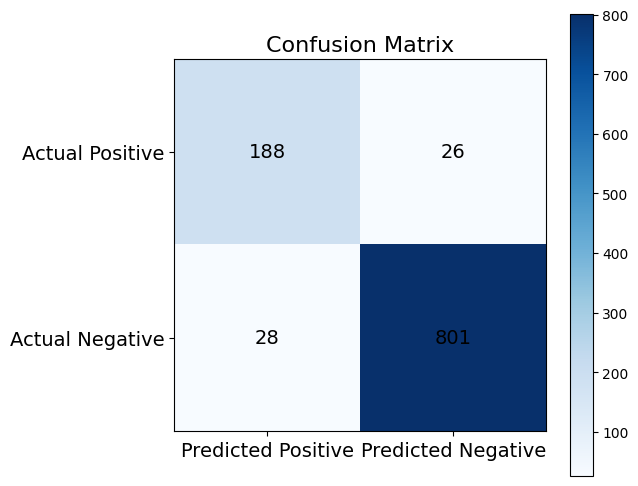

Test Accuracy: 0.9482262703739214
Test Precision: 0.8703703703703703
Test recal: 0.8785046728971962
Test f1_score: 0.8744186046511628
Test Error: 0.05465004793863854  Test Loss:0.005604501760074528


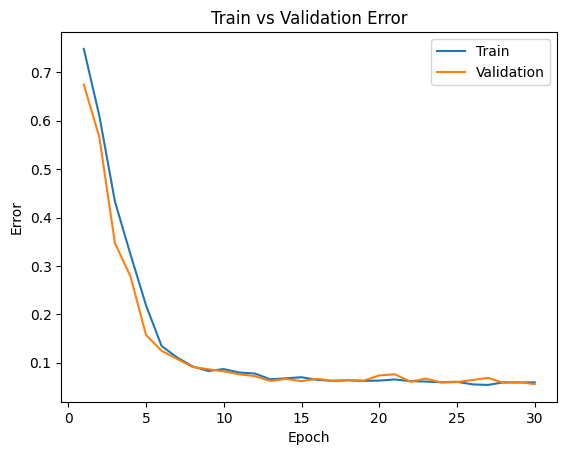

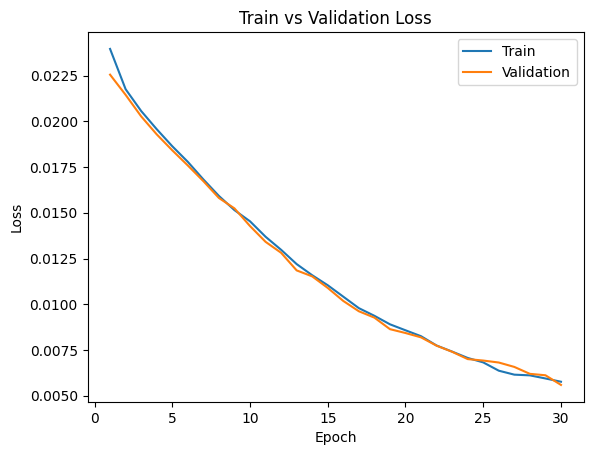

In [331]:
# Prepare device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Instantiate model
num_features = 2
num_classes =1
net = catchProb(num_features, num_classes).to(device)


batch_size = 628
learning_rate = 0.0001
num_epochs = 30

# Load data
train_loader, valid_loader, test_loader = data_loader('modelData_1.csv')

# Train model
train(net, device, train_loader, valid_loader, test_loader, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name(batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs-1)

plot_training_curve(model_path)
